#### Reference: http://brandonrose.org/clustering

In [1]:
first_time = True

In [1]:
import string
#from collections import Counter
import pickle
import joblib

import numpy as np
import pandas as pd
import nltk
import re
import os
#import codecs
#from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
#import mpld3
%matplotlib inline 



from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize

# Document Dataframe

In [19]:
import csv

with open('filenames.csv', 'w') as csvfile:
    filenames = csv.writer(csvfile, delimiter = ',')
    filenames.writerow(['document_id','file_name', 'label'])
    rows = []
    num = -1
    for filename in os.listdir('clean_text'):
        with open(os.path.join('clean_text', filename), 'r') as f:
            num +=1
            file_name = "clean_text/" + filename
            pattern = r'([^D]+)'
            match = re.findall(pattern, filename)
            label = match[0].strip("_")
            #print(label)
            row=[num, file_name, label]
            print(row)
            rows.append(row)
    filenames.writerows(rows)

[0, 'clean_text/_UNK_DEF 14A_20181025_0001437749-18-017878.txt', 'UNK']
[1, 'clean_text/AYI_DEF 14A_20180831_0001144215-18-000131.txt', 'AYI']
[2, 'clean_text/_UNK_DEF 14A_20181129_0001213900-18-014145.txt', 'UNK']
[3, 'clean_text/_UNK_DEF 14A_20181128_0000051931-18-001097.txt', 'UNK']
[4, 'clean_text/_UNK_DEF 14A_20190124_0001387131-18-006916.txt', 'UNK']
[5, 'clean_text/ARCW_DEF 14A_20181204_0001558370-18-007990.txt', 'ARCW']
[6, 'clean_text/ARAY_DEF 14A_20181116_0001193125-18-293274.txt', 'ARAY']
[7, 'clean_text/APD_DEF 14A_20190124_0001206774-18-003394.txt', 'AP']
[8, 'clean_text/_UNK_DEF 14A_20181018_0001104659-18-060984.txt', 'UNK']
[9, 'clean_text/DIT_DEF 14A_20181116_0001014108-18-000226.txt', 'IT']
[10, 'clean_text/ARL_DEF 14A_20181212_0001387131-18-006070.txt', 'ARL']
[11, 'clean_text/_UNK_DEF 14A_20190124_0001398344-18-017899.txt', 'UNK']
[12, 'clean_text/AOSL_DEF 14A_20181109_0001387467-18-000053.txt', 'AOSL']
[13, 'clean_text/AMTY_DEF 14A_20181128_0001185185-18-001854.txt'

In [2]:
documents = pd.read_csv("filenames.csv", index_col = 'document_id')
#documents['file_name']=documents['file_name'].apply(lambda x: "clean_text/"+ x )
documents.head()

,file_name,label
document_id,,
0,clean_text/_UNK_DEF 14A_20181025_0001437749-18...,UNK
1,clean_text/AYI_DEF 14A_20180831_0001144215-18-...,AYI
2,clean_text/_UNK_DEF 14A_20181129_0001213900-18...,UNK
3,clean_text/_UNK_DEF 14A_20181128_0000051931-18...,UNK
4,clean_text/_UNK_DEF 14A_20190124_0001387131-18...,UNK


## Stopwords, stemming and tokenizing

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annamontserratguerrero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/annamontserratguerrero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#stopwords = nltk.corpus.stopwords.words('english')

In [4]:
#print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


## Stemming: process of breaking a word down into its root.

In [3]:
# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [4]:
#BR functions
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
#Emily;s function
def stem_tokenizer(text):
    porter_stemmer=PorterStemmer()
    return [porter_stemmer.stem(token) for token in word_tokenize(text.lower())]

# remove html entities from docs and
# set everything to lowercase
def my_preprocessor(text):
    if (type(text) is not list):
        text=text.split('\n')
    text=" ".join(text).replace("\n"," ").replace('\u200b', '').replace('\n', '')
    return text

def process_text(filename,stop): #removes stopwords
    porter_stemmer = PorterStemmer()
    file=open(filename)
    lines=file.readlines()
    text=" ".join(lines).replace("\n"," ").replace('\u200b', '').replace('\n', '')
    stem_list=stem_tokenizer(text)
    used_list=[token for token in stem_list if token not in stop_words]
    #used_list.remove('\u200b')
    return used_list

In [6]:
#Emily's function

# tokenize the doc and lemmatize its tokens
def my_tokenizer(text):
    porter_stemmer = PorterStemmer()
    punctuation=list(string.punctuation)
    stop0=" ".join(stopwords.words("english")+punctuation)
    stop_words=set(stem_tokenizer(stop0))
    stem_list=stem_tokenizer(text)
    used_list=[token for token in stem_list if token not in stop_words]
    return used_list

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)


#### Testing on one document

In [37]:
#Test on one document
f = open(documents['file_name'].loc[0],"r")
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in f:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed) #stemmed
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized) #tokenized
    


In [7]:
#No need to run
#Emily's code
filename=documents["file_name"][10]
punctuation=list(string.punctuation)
stop0=" ".join(stopwords.words('english')+punctuation) #all words to be removed
stop_words=set(stem_tokenizer(stop0))
stems=process_text(filename,stop_words) #returns totalvocab_stemmed: stemmed words

# DataFrame with tokenized words

In [9]:
documents['clean_text']=documents['file_name'].apply(lambda x: process_text(filename, stop_words))
documents['clean_text']

document_id
0     [unit, state, secur, exchang, commiss, washing...
1     [unit, state, secur, exchang, commiss, washing...
2     [unit, state, secur, exchang, commiss, washing...
3     [unit, state, secur, exchang, commiss, washing...
4     [unit, state, secur, exchang, commiss, washing...
5     [unit, state, secur, exchang, commiss, washing...
6     [unit, state, secur, exchang, commiss, washing...
7     [unit, state, secur, exchang, commiss, washing...
8     [unit, state, secur, exchang, commiss, washing...
9     [unit, state, secur, exchang, commiss, washing...
10    [unit, state, secur, exchang, commiss, washing...
11    [unit, state, secur, exchang, commiss, washing...
12    [unit, state, secur, exchang, commiss, washing...
13    [unit, state, secur, exchang, commiss, washing...
14    [unit, state, secur, exchang, commiss, washing...
15    [unit, state, secur, exchang, commiss, washing...
16    [unit, state, secur, exchang, commiss, washing...
17    [unit, state, secur, exchang, 

In [15]:
#No need to run; description: for all words in one txt file
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in text:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    

# DataFrame of all words from one file

In [12]:
#No need to run
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print("There are " + str(vocab_frame.shape[0]) + ' items in the data frame.')

There are 20385 items in the data frame.


In [43]:
print(vocab_frame.shape)
vocab_frame

(20385, 1)


,words
tabl,table
of,of
content,contents
schedul,schedule
14a,14a
...,...
chief,chief
execut,executive
offic,officer
end,end


## TF IDF document similarity

#### Unigram

In [95]:
#Emily's code
#ngram_range = 1,1
tfidf_vectorizer=TfidfVectorizer(input='filename', preprocessor=my_preprocessor, tokenizer=my_tokenizer)
X_tfidf=tfidf_vectorizer.fit_transform(documents["file_name"])
X_tfidf = normalize(X_tfidf) #explains why we normalize: https://www.quora.com/What-is-the-benefit-of-normalization-in-the-tf-idf-algorithm
tfidf_features = tfidf_vectorizer.get_feature_names()
# create a dataframe from the matrix
wm2df(X_tfidf, tfidf_features)

,,'','at,'execut,'for,'reason,**,***,*****************,*if,...,—mr,—our,——————————————,†,††,•,●,◻,☐,☒
Doc0,0.000000,0.133051,0.002612,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.001456,0.006597,0.000000,0.009386,0.004125
Doc1,0.000000,0.060484,0.000000,0.000000,0.000000,0.00169,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.245900,0.000000,0.000000,0.000000,0.000000
Doc2,0.000000,0.101696,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.014059,0.000000,0.015003,0.000000
Doc3,0.000000,0.000000,0.000000,0.000000,0.034626,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Doc4,0.002993,0.051517,0.000000,0.000000,0.000000,0.00000,0.026936,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.007362,0.004314
Doc5,0.000000,0.116797,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.003552,0.011168,0.005609
Doc6,0.000000,0.112539,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.069001,0.000000,0.000000,0.000556,0.000652
Doc7,0.005004,0.066990,0.000000,0.000000,0.000000,0.00000,0.001668,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.067762,0.000000,0.006154,0.000000
Doc8,0.002768,0.086736,0.000000,0.000000,0.000000,0.00000,0.008303,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.015159,0.00379,0.000000,0.000000,0.000000,0.000000,0.000000
Doc9,0.000000,0.113134,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.004229,0.000000,0.00000,0.002357,0.000000,0.000000,0.011395,0.000000


In [98]:
#Convert to DF Unigram
tf_idf_array_1 = X_tfidf.toarray()
uni_df = pd.DataFrame(tf_idf_array_1, columns=tfidf_features)

## Dataframe of Unigram

In [108]:
uni_df.head()

,,'','at,'execut,'for,'reason,**,***,*****************,*if,...,—mr,—our,——————————————,†,††,•,●,◻,☐,☒
0,0.000000,0.133051,0.002612,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.001456,0.006597,0.0,0.009386,0.004125
1,0.000000,0.060484,0.000000,0.0,0.000000,0.00169,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.245900,0.000000,0.0,0.000000,0.000000
2,0.000000,0.101696,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.014059,0.0,0.015003,0.000000
3,0.000000,0.000000,0.000000,0.0,0.034626,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,0.002993,0.051517,0.000000,0.0,0.000000,0.00000,0.026936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.007362,0.004314


In [141]:
documents['label']

document_id
0      UNK
1      AYI
2      UNK
3      UNK
4      UNK
5     ARCW
6     ARAY
7       AP
8      UNK
9       IT
10     ARL
11     UNK
12    AOSL
13    AMTY
14    AHPI
15    AGTC
16    EPAC
17     UNK
18    AKRX
19     UNK
20    FLWS
Name: label, dtype: object

### KMeans for Unigram

In [109]:
num_clusters = 5

uni_km = KMeans(n_clusters=num_clusters)

uni_km.fit(X_tfidf)

uni_clusters = km.labels_.tolist() #labels

Text(0.5, 1.0, 'Elbow curve')

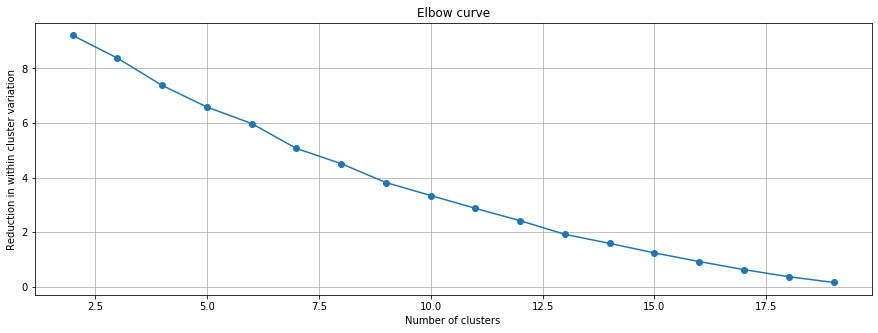

In [110]:
within_cluster_variance = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_tfidf)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')

plt.title('Elbow curve') 

In [111]:
#After Pickling and getting the clusters

joblib.dump(uni_km,  'uni_doc_cluster.pkl') #pickle doc

uni_km_load = joblib.load('uni_doc_cluster.pkl')
uni_clusters = uni_km_load.labels_.tolist() #labels

uni_clust_centers = uni_km_load.cluster_centers_ # centers

### Top Keywords in Unigram dataframe

In [113]:
def get_top_keywords(df, clusters, labels, n_terms): #n_terms: no of words
    #df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.groupby(clusters).mean().iterrows(): #group by cluster means
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(uni_df, uni_clusters, tfidf_features, 10)


Cluster 0
director,compens,tabl,vote,compani,option,plan,stock,award,share

Cluster 1
meet,advis,vote,proxi,board,truste,sharehold,aberdeen,clarkston,fund

Cluster 2
bdc,advis,issuer,may,bond,debt,risk,secur,fund,invest

Cluster 3
annual,share,offic,vote,board,execut,committe,compens,compani,director

Cluster 4
fee,incom,seri,file,world,america,tax-exempt,bond,american,fund


### Unigram Visualization

In [131]:
dist = 1 - cosine_similarity(X_tfidf)
dist.shape

(21, 21)

In [117]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

Create Colors and Cluster names

In [120]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'director,compens,tabl,vote,compani,option,plan,stock,award,share', 
                 1: 'meet,advis,vote,proxi,board,truste,sharehold,aberdeen,clarkston,fund', 
                 2: 'bdc,advis,issuer,may,bond,debt,risk,secur,fund,invest', 
                 3: 'annual,share,offic,vote,board,execut,committe,compens,compani,director', 
                 4: 'fee,incom,seri,file,world,america,tax-exempt,bond,american,fund'}

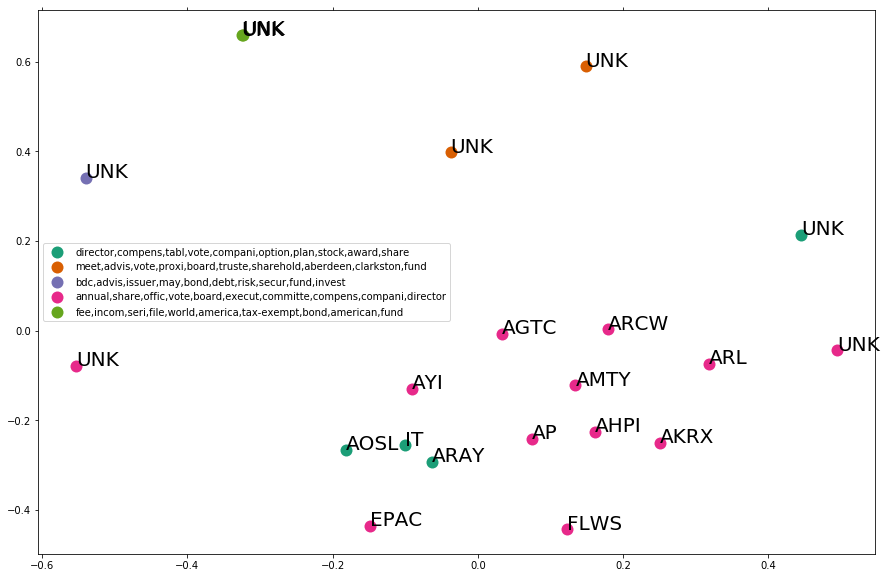

In [152]:

%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers
plot_uni_df = pd.DataFrame(dict(x=xs, y=ys, document = documents['label'], label=uni_clusters)) 

groups = plot_uni_df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(plot_uni_df)):
     ax.text(plot_uni_df.iloc[i]['x'], plot_uni_df.iloc[i]['y'], 
             plot_uni_df.iloc[i]['document'], size=20)  

    
    
plt.show() #show the plot

#### Digram

In [15]:
#ngram_range = 2,2
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(input = "filename",  ngram_range=(2,2), 
                                   tokenizer=my_tokenizer, preprocessor = my_preprocessor)

tfidf_matrix = tfidf_vectorizer.fit_transform(documents['file_name'])
tfidf_matrix = normalize(tfidf_matrix)
tfidf_features_1 = tfidf_vectorizer.get_feature_names()
# create a dataframe from the matrix
wm2df(tfidf_matrix, tfidf_features_1)

, david, end, matthew, propos, tabl, truste,'' '','' **,"'' 1,300,000","'' 1,430,000",...,☐ solicit,☐ three,☐ two,☐ withhold,☐ ☐,☒ definit,☒ end,☒ fee,☒ file,☒ use
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010488,0.000000,0.000000,0.000000,...,0.001697,0.000000,0.000000,0.000000,0.000000,0.001697,0.000000,0.001592,0.001415,0.000000
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Doc2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018540,0.000000,0.004752,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.016078,0.000000,0.000000,0.000000,0.000000,0.000000
Doc3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.003974,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002353,0.002092,0.000000
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009235,0.000000,0.000000,0.000000,...,0.003487,0.000000,0.000000,0.000000,0.000000,0.003487,0.000000,0.003270,0.002907,0.000000
Doc6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001271,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001201,0.000000
Doc7,0.003654,0.003654,0.003654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.009889,0.000000,0.000000,0.000000,0.000000,0.000000
Doc8,0.000000,0.000000,0.000000,0.006051,0.000000,0.000000,0.000000,0.006051,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Doc9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.015988,0.000000,0.000000,0.000000,0.000000,0.000000


In [93]:
#convert to DF
tf_idf_array = tfidf_matrix.toarray()
new_df = pd.DataFrame(tf_idf_array, columns=tfidf_features_1)

## TF-IDF Dataframe of Digram

In [18]:
new_df.head()

, david, end, matthew, propos, tabl, truste,'' '','' **,"'' 1,300,000","'' 1,430,000",...,☐ solicit,☐ three,☐ two,☐ withhold,☐ ☐,☒ definit,☒ end,☒ fee,☒ file,☒ use
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.010488,0.0,0.000000,0.0,...,0.001697,0.0,0.0,0.0,0.000000,0.001697,0.0,0.001592,0.001415,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.018540,0.0,0.004752,0.0,...,0.000000,0.0,0.0,0.0,0.016078,0.000000,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.003974,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002353,0.002092,0.0


### K- Means Clustering of Digrams

In [20]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)



clusters = km.labels_.tolist() #Labels of each point (if compute_labels is set to True).

In [102]:
km_text = km.transform(tfidf_matrix) #transform X to cluster distance space

In [47]:
#NO need to run
#Document Clustering notebook
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

Text(0.5, 1.0, 'Elbow curve')

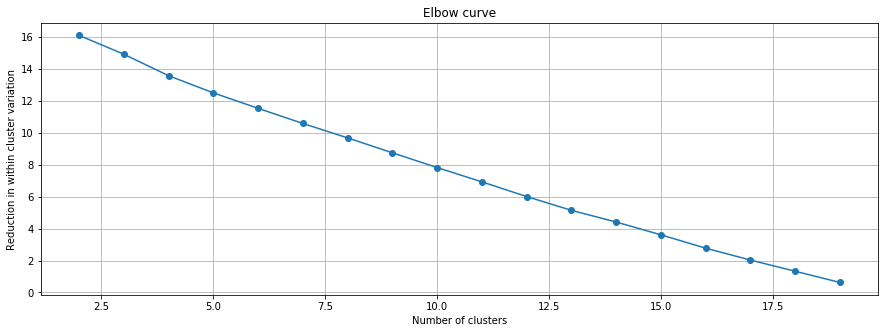

In [25]:
within_cluster_variance = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')

plt.title('Elbow curve') 

In [44]:
#After Pickling and getting the clusters
joblib.dump(km,  'doc_cluster.pkl') #pickle doc

km_load = joblib.load('doc_cluster.pkl')
clusters = km_load.labels_.tolist() #labels

clust_centers = km_load.cluster_centers_ # centers

### Get Top 5 Keywords in Digram Dataframe

In [114]:
get_top_keywords(new_df, clusters, tfidf_features_1, 10)


Cluster 0
tabl •,offer period,restrict stock,compens committe,end tabl,begin tabl,fiscal 2018,common share,execut offic,— —

Cluster 1
fund tax-exempt,growth incom,fund new,tax-exempt bond,incom fund,seri american,fund america,bond fund,fund american,american fund

Cluster 2
proxi statement,fiscal year,compens committe,begin tabl,end tabl,common stock,audit committe,execut offic,annual meet,board director

Cluster 3
truste servic,new advisori,particular knowledg,debt secur,aberdeen asset,underli fund,board truste,fund invest,servic commenc,advisori agreement

Cluster 4
accord direct,favor item,person entitl,proxi form,direct proxi,option exchang,list rule,disregard vote,compani disregard,asx list


## PCA to reduce dimensions

- extra step before plotting

In [19]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [22]:
km_clusters = km.fit_predict(tfidf_matrix) #Compute cluster centers and predict cluster index for each sample.
km_clusters

array([4, 0, 2, 1, 3, 2, 0, 0, 3, 2, 2, 3, 0, 2, 2, 2, 0, 3, 2, 1, 2],
      dtype=int32)

## Digram Visualization